# Dog breed identification

Here we train a deep learning algorythm to identify the breed of a dog from a photography. We use different methods : VGG16 from scratch, VGG16 transfered and EfficientNetB7 transfered.

As such CNN constitute state of the art methods in image recognition it is an interesting choice of programs. We remind here that CNNs are hegemonic in this domain, over other machine learning technique, thanks to their specific architecture allowing them to reduce parameters number through convolutional layers and therefore schrinking computation time and avoiding overfitting.     

Training was done with a google collab GPU (40gb vram)

The original data is the Stanford Dogs dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/)

In [2]:
!pip install keras-tuner
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from keras import metrics
from IPython.display import SVG
import pydot
import graphviz
from keras import backend as K
from tensorflow.keras import layers
from tensorflow import keras
from imgaug import augmenters as iaa
import imgaug as ia
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import keras_tuner
import torch
import torchvision
import timm
import time
import pandas as pd


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#data_dir = r"C:\Users\alexh\Projet_6/Images10"
data_dir = "drive/MyDrive/Images10"

results = pd.DataFrame(columns=['MODEL', 'BATCH_SIZE',"OPTIMIZER","LOSS_FUNCTION","EPOCHS","TRAIN_TIME","VAL_ACCURACY"])
results

,MODEL,BATCH_SIZE,OPTIMIZER,LOSS_FUNCTION,EPOCHS,TRAIN_TIME,VAL_ACCURACY


In [6]:
#Loading images (10 classes)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="both",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)



Found 1919 files belonging to 10 classes.
Using 1536 files for training.
Using 383 files for validation.


In [ ]:
plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
  for i in range(1):
    rgb = images[i].numpy().astype("uint8")
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]    
    plt.imshow(r)
    print(np.max(r))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Example of data augmentation with Keras
data_augmentation_test = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomContrast(0.2),
                                      layers.RandomBrightness([-0.8,0.8]),
                                      layers.Rescaling(scale=1 / 255)
                                      ])

plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
  for i in range(1):
    rgb = data_augmentation_test(images[i].numpy().astype("uint8"))
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]    
    plt.imshow(r)
    print(np.max(r))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
#Example of data preprocessing with OpenCV (simple rotation)

import cv2 as cv


for images, labels in train_ds.take(1):
  for i in range(1):
    img = images[i].numpy().astype("uint8")




rows,cols,plans = img.shape
# cols-1 and rows-1 are the coordinate limits.
M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),90,1)
dst = cv.warpAffine(img,M,(cols,rows))


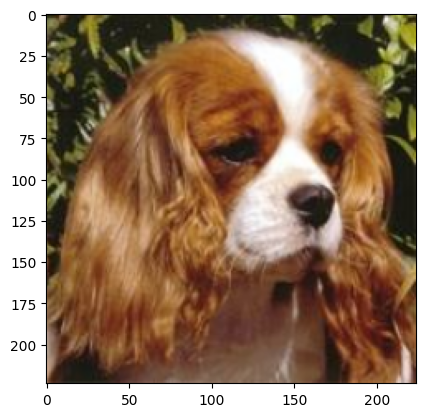

In [19]:
plt.imshow(img)

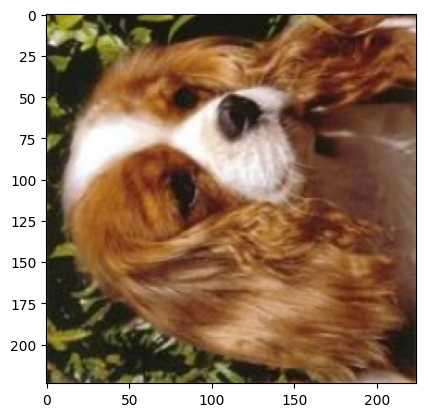

In [18]:
plt.imshow(dst)

## VGG16 from scratch (10 classes)

In [20]:
def plot_model_metric(model,title):

    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(title)

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.ylabel('Cross Entropy loss')
    plt.xlabel('epoch')
    plt.show()


def train_model(model,
                train_data,
                validation_data,
                ModelCheckpointStr,
                MODEL_NAME,
                EPOCHS,
                OPTIMIZER_NAME,
                LOSS_FUNCTION):
  
  #Callbacks
  es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   verbose=1,
                   min_delta=0.01,
                   patience=10)


  mc = ModelCheckpoint(ModelCheckpointStr,
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)

  start_time = time.time()
  history = model.fit(train_data,
                      epochs=EPOCHS,
                      validation_data=validation_data,
                      callbacks=[es, mc])

  train_time = time.time()-start_time
  val_acc_max = max(history.history['val_accuracy'])


  new_row = pd.Series({'MODEL':MODEL_NAME,
                      'BATCH_SIZE':BATCH_SIZE,
                      "OPTIMIZER":OPTIMIZER_NAME,
                      "LOSS_FUNCTION":LOSS_FUNCTION,
                      'EPOCHS':EPOCHS,
                      'TRAIN_TIME':train_time,
                      'VAL_ACCURACY': val_acc_max})

  global results
  results = pd.concat([results, new_row.to_frame().T], ignore_index=True)

  plot_model_metric(history,MODEL_NAME)

  results

  return model

def unfreeze_model(model):
    # We unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True



In [21]:
def build_model_VGG16_fromscratch(hp):
  
  #data augmentation layer
  data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(0.2),
                                        layers.RandomBrightness([-0.8,0.8])
                                        ])


  # input  
  input = Input(shape =(224,224,3))
  rescaled = layers.Rescaling(scale=1./255.)
  input = rescaled(input)
  xaug = data_augmentation(input)  # Apply random data augmentation

  # 1st Conv Block

  x1 = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(xaug)
  x2 = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x1)
  x3 = MaxPool2D(pool_size =2, strides =2, padding ='same')(x2)

  # 2nd Conv Block

  x4 = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x3)
  x5 = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x4)
  x6 = MaxPool2D(pool_size =2, strides =2, padding ='same')(x5)

  # 3rd Conv block  
  x7 = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x6) 
  x8 = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x7) 
  x9 = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x8) 
  x10 = MaxPool2D(pool_size =2, strides =2, padding ='same')(x9)

  # 4th Conv block

  x11 = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x10)
  x12 = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x11)
  x13 = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x12)
  x14 = MaxPool2D(pool_size =2, strides =2, padding ='same')(x13)

  # 5th Conv block

  x15 = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x14)
  x16 = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x15)
  x17 = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x16)
  x18 = MaxPool2D(pool_size =2, strides =2, padding ='same')(x17)

  # Fully connected layers  
  x19 = Flatten()(x18) 
  x20 = Dense(units = 4096, activation ='relu')(x19) 
  x21 = Dense(units = 4096, activation ='relu')(x20) 
  output = Dense(units = 10, activation ='softmax')(x21)

  # creating the model

  model = Model(inputs=input, outputs =output)


  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return model

           


In [ ]:
#Tunning hyperparameter learning rate
tuner = keras_tuner.RandomSearch(
    build_model_VGG16_fromscratch,
    objective='val_accuracy',
    max_trials=5)

tuner.search(train_ds,
             epochs=3,
             validation_data=val_ds)

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.08093994855880737

Best val_accuracy So Far: 0.20365534722805023
Total elapsed time: 00h 03m 28s


Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 2.2439 - accuracy: 0.1803
Epoch 1: val_accuracy improved from -inf to 0.18799, saving model to best_model1.h5
48/48 [==============================] - 12s 123ms/step - loss: 2.2439 - accuracy: 0.1803 - val_loss: 2.1958 - val_accuracy: 0.1880
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 2.2022 - accuracy: 0.1797
Epoch 2: val_accuracy improved from 0.18799 to 0.19060, saving model to best_model1.h5
48/48 [==============================] - 8s 172ms/step - loss: 2.2022 - accuracy: 0.1797 - val_loss: 2.1467 - val_accuracy: 0.1906
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 2.1779 - accuracy: 0.1777
Epoch 3: val_accuracy did not improve from 0.19060
48/48 [==============================] - 3s 69ms/step - loss: 2.1779 - accuracy: 0.1777 - val_loss: 2.2058 - val_accuracy: 0.1749
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss: 2.1520 - accuracy: 0.2038
Epoch 4: 

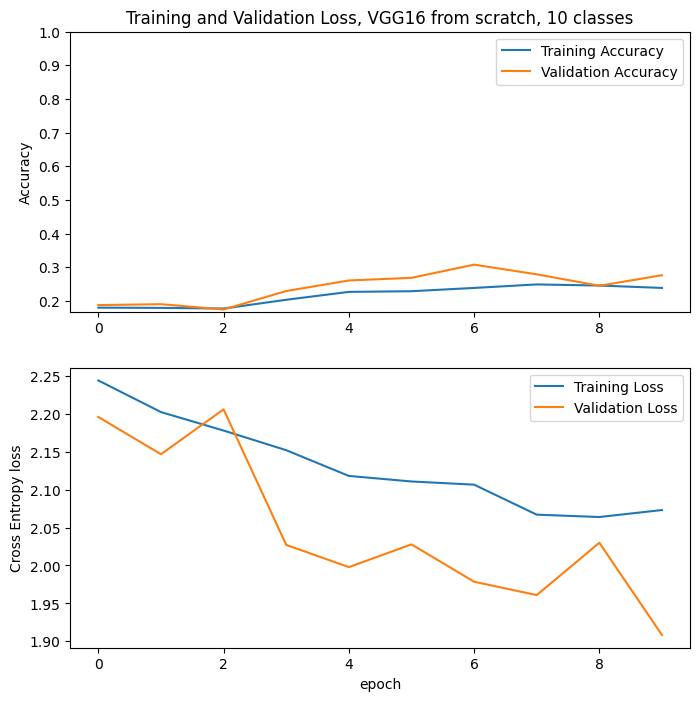

In [ ]:


#automaticaly return the model with optimal hyperparameter
best_model = tuner.get_best_models()[0]





model = best_model




train_model(model = best_model,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model1.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 from scratch, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")


## VGG16 transfered (10 classes)

As a CNN become more competent through training time and diversity of data it is really beneficial to recycle models that have been trained on huge datasets for large amount of time (in this example VGG16 has been trained on Imagenet, a dataset acounting for 20k+ diverse images). Thereby, we will here take advantage of a core CNN for which the internal wheights have been already precisely tuned for image recognition and adapt it to our specific dog breed identification problem.  

58889256/58889256 [==============================] - 6s 0us/step
Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 6.7139 - accuracy: 0.2454
Epoch 1: val_accuracy improved from -inf to 0.42820, saving model to best_model2.h5
48/48 [==============================] - 343s 7s/step - loss: 6.7139 - accuracy: 0.2454 - val_loss: 1.5380 - val_accuracy: 0.4282
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 1.0596 - accuracy: 0.6100
Epoch 2: val_accuracy improved from 0.42820 to 0.59008, saving model to best_model2.h5
48/48 [==============================] - 17s 345ms/step - loss: 1.0596 - accuracy: 0.6100 - val_loss: 1.1436 - val_accuracy: 0.5901
Epoch 3/10
47/48 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8391
Epoch 3: val_accuracy did not improve from 0.59008
48/48 [==============================] - 9s 163ms/step - loss: 0.4272 - accuracy: 0.8392 - val_loss: 1.4466 - val_accuracy: 0.5901
Epoch 4/10
48/48 [====================

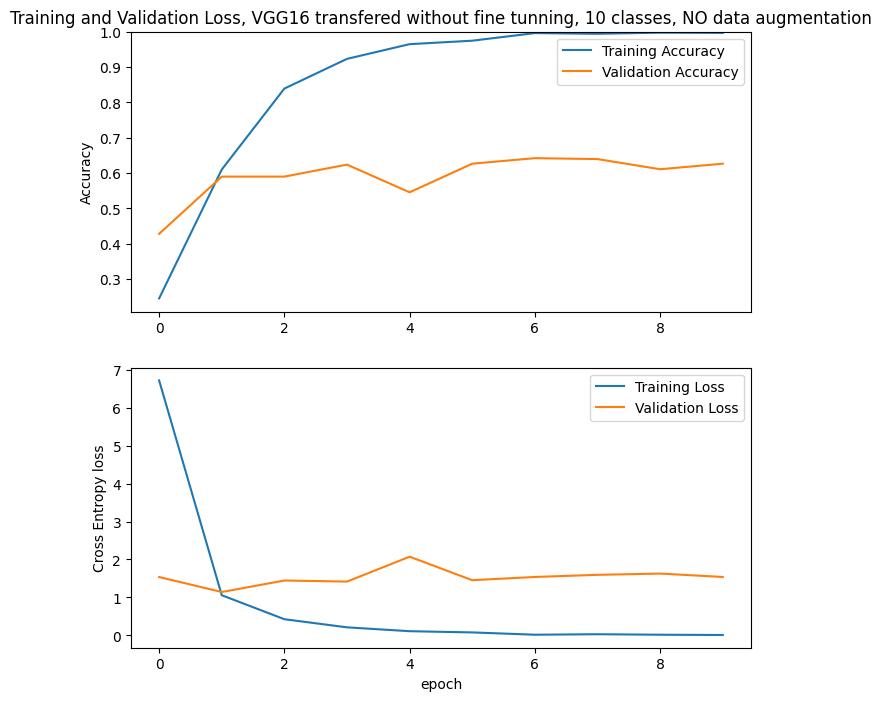

In [22]:
#Without Data augmentation for baseline

base_modeltbis = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,
                                               input_shape=(224, 224, 3),
                                               pooling=None,
                                               classes=10,
                                               classifier_activation='softmax')

# Freeze the base_model
base_modeltbis.trainable = False

# Create new model on top
inputst = tf.keras.Input(shape=(224,224,3))


xt1 = inputst

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (0,1)
scale_layert = tf.keras.layers.Rescaling(scale=1 / 255)
xt2 = scale_layert(xt1)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
xt3 = base_modeltbis(xt2, training=False)


# Fully connected layers  
xt4 = Flatten()(xt3) 
xt5 = Dense(units = 4096, activation ='relu')(xt4) 
xt6 = Dense(units = 4096, activation ='relu')(xt5) 
outputt = Dense(units = 10, activation ='softmax')(xt6)

# creating the model

modeltbis = Model(inputs=inputst, outputs =outputt)

modeltbis.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



train_model(model = modeltbis,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model2.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 transfered without fine tunning, 10 classes, NO data augmentation",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")






The lack of data augmentation is clearly visible here with a strong overfitting of the model. The interest of data augmentation is well kwnown for CNN networks as it simulate a larger dataset by randomly altering the input data, allowing the model to train on more heterogenious data and thus improving its robustness against noisy extern data.   

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 5.7796 - accuracy: 0.1087
Epoch 1: val_accuracy improved from -inf to 0.25065, saving model to best_model3.h5
48/48 [==============================] - 22s 390ms/step - loss: 5.7796 - accuracy: 0.1087 - val_loss: 2.1003 - val_accuracy: 0.2507
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 2.1101 - accuracy: 0.2188
Epoch 2: val_accuracy improved from 0.25065 to 0.36815, saving model to best_model3.h5
48/48 [==============================] - 17s 352ms/step - loss: 2.1101 - accuracy: 0.2188 - val_loss: 1.7794 - val_accuracy: 0.3681
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 1.9343 - accuracy: 0.2865
Epoch 3: val_accuracy did not improve from 0.36815
48/48 [==============================] - 10s 203ms/step - loss: 1.9343 - accuracy: 0.2865 - val_loss: 1.7047 - val_accuracy: 0.3499
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss: 1.8633 - accuracy: 0.3086
Epoch 

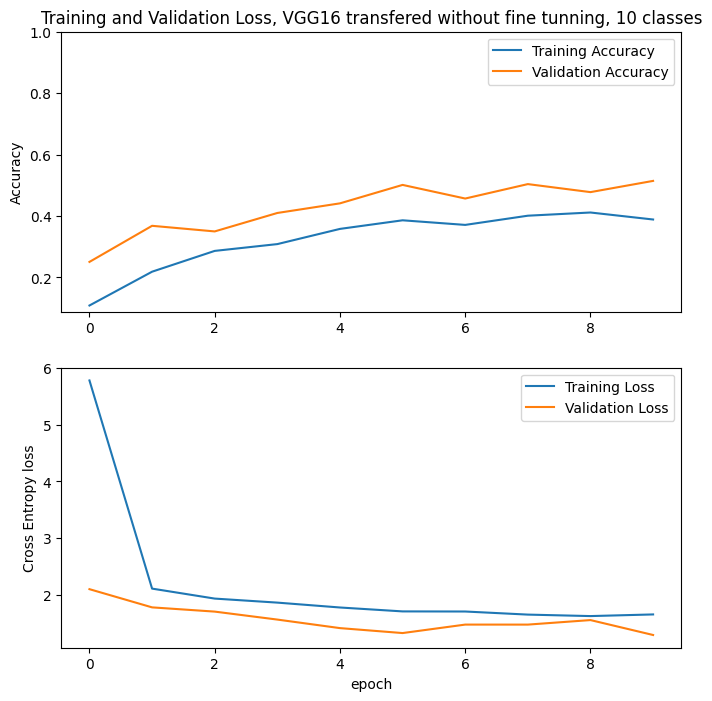

In [23]:
base_modelt = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,
                                               input_shape=(224, 224, 3),
                                               pooling=None,
                                               classes=10,
                                               classifier_activation='softmax')

#data augmentation layer
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(0.2),
                                        layers.RandomBrightness([-0.8,0.8])
                                        ])

# Freeze the base_model
base_modelt.trainable = False

# Create new model on top
inputst = tf.keras.Input(shape=(224,224,3))


xt1 = data_augmentation(inputst)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (0,1)
scale_layert = tf.keras.layers.Rescaling(scale=1 / 255)
xt2 = scale_layert(xt1)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
xt3 = base_modelt(xt2, training=False)


# Fully connected layers  
xt4 = Flatten()(xt3) 
xt5 = Dense(units = 4096, activation ='relu')(xt4) 
xt6 = Dense(units = 4096, activation ='relu')(xt5) 
outputt = Dense(units = 10, activation ='softmax')(xt6)

# creating the model

modelt = Model (inputs=inputst, outputs =outputt)

modelt.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])




model = train_model(model = modelt,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model3.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 transfered without fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")

In [24]:
results

,MODEL,BATCH_SIZE,OPTIMIZER,LOSS_FUNCTION,EPOCHS,TRAIN_TIME,VAL_ACCURACY
0,"Training and Validation Loss, VGG16 transfered...",32,Adam,SparseCategoricalCrossentropy,10,452.827556,0.642298
1,"Training and Validation Loss, VGG16 transfered...",32,Adam,SparseCategoricalCrossentropy,10,155.943029,0.51436


Epoch 1/10
47/48 [============================>.] - ETA: 0s - loss: 2.5555 - accuracy: 0.1077
Epoch 1: val_accuracy improved from -inf to 0.11749, saving model to best_model3.h5
48/48 [==============================] - 5s 79ms/step - loss: 2.5492 - accuracy: 0.1074 - val_loss: 2.3673 - val_accuracy: 0.1175
Epoch 2/10
47/48 [============================>.] - ETA: 0s - loss: 2.3257 - accuracy: 0.1190
Epoch 2: val_accuracy did not improve from 0.11749
48/48 [==============================] - 2s 36ms/step - loss: 2.3271 - accuracy: 0.1172 - val_loss: 2.3261 - val_accuracy: 0.1044
Epoch 3/10
47/48 [============================>.] - ETA: 0s - loss: 2.3038 - accuracy: 0.1210
Epoch 3: val_accuracy did not improve from 0.11749
48/48 [==============================] - 2s 36ms/step - loss: 2.3039 - accuracy: 0.1191 - val_loss: 2.3066 - val_accuracy: 0.1175
Epoch 4/10
47/48 [============================>.] - ETA: 0s - loss: 2.2994 - accuracy: 0.1263
Epoch 4: val_accuracy did not improve from 0.117

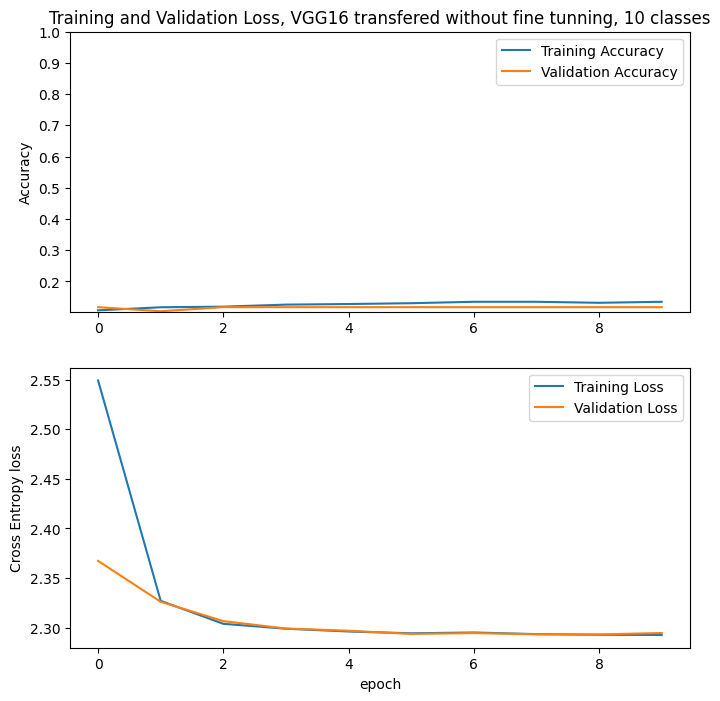

In [ ]:
#Testing a different optimizer

#data augmentation layer
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(0.2),
                                        layers.RandomBrightness([-0.8,0.8]),
                                        layers.Rescaling(scale=1./255.)
                                        ])
  
base_modelt = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,
                                               input_shape=(224, 224, 3),
                                               pooling=None,
                                               classes=10,
                                               classifier_activation='softmax')


# Freeze the base_model
base_modelt.trainable = False

# Create new model on top
inputst = tf.keras.Input(shape=(224,224,3))


xt1 = data_augmentation(inputst)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (0,1)
scale_layert = tf.keras.layers.Rescaling(scale=1 / 255)
xt2 = scale_layert(xt1)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
xt3 = base_modelt(xt2, training=False)


# Fully connected layers  
xt4 = Flatten()(xt3) 
xt5 = Dense(units = 4096, activation ='relu')(xt4) 
xt6 = Dense(units = 4096, activation ='relu')(xt5) 
outputt = Dense(units = 10, activation ='softmax')(xt6)

# creating the model

modelt = Model (inputs=inputst, outputs =outputt)

modelt.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

train_model(model = modelt,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model3.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 transfered without fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "SGD",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")

Epoch 1/10
47/48 [============================>.] - ETA: 0s - loss: 130.8555 - accuracy: 0.0904
Epoch 1: val_accuracy improved from -inf to 0.09661, saving model to best_model4.h5
48/48 [==============================] - 6s 85ms/step - loss: 130.7737 - accuracy: 0.0905 - val_loss: 135.2153 - val_accuracy: 0.0966
Epoch 2/10
47/48 [============================>.] - ETA: 0s - loss: 133.3923 - accuracy: 0.0884
Epoch 2: val_accuracy did not improve from 0.09661
48/48 [==============================] - 2s 37ms/step - loss: 133.1632 - accuracy: 0.0879 - val_loss: 135.2153 - val_accuracy: 0.0966
Epoch 3/10
47/48 [============================>.] - ETA: 0s - loss: 133.2958 - accuracy: 0.0878
Epoch 3: val_accuracy did not improve from 0.09661
48/48 [==============================] - 2s 37ms/step - loss: 133.1632 - accuracy: 0.0879 - val_loss: 135.2153 - val_accuracy: 0.0966
Epoch 4/10
47/48 [============================>.] - ETA: 0s - loss: 133.1029 - accuracy: 0.0871
Epoch 4: val_accuracy did no

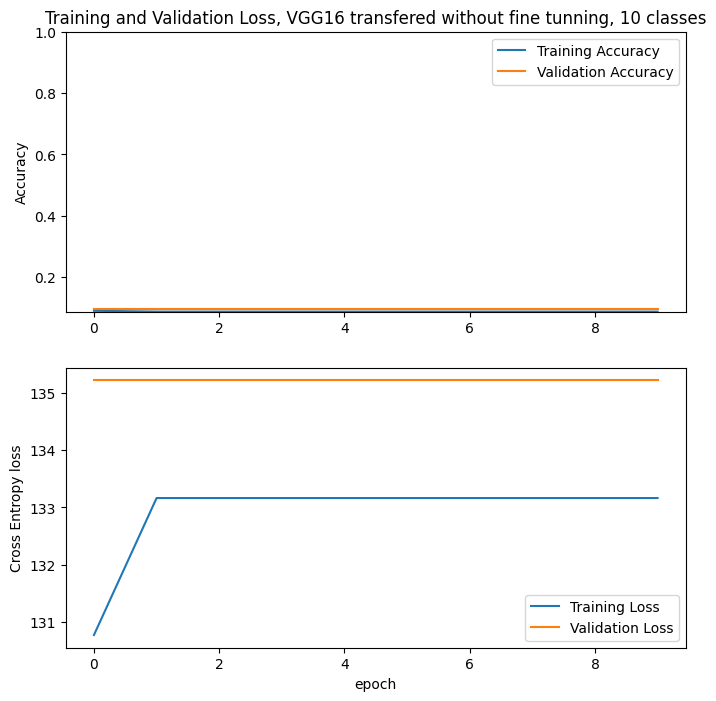

In [ ]:
#Testing a different loss function

base_modelt = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,
                                               input_shape=(224, 224, 3),
                                               pooling=None,
                                               classes=10,
                                               classifier_activation='softmax')

#data augmentation layer
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(0.2),
                                        layers.RandomBrightness([-0.8,0.8])
                                        ])

# Freeze the base_model
base_modelt.trainable = False

# Create new model on top
inputst = tf.keras.Input(shape=(224,224,3))


xt1 = data_augmentation(inputst)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (0,1)
scale_layert = tf.keras.layers.Rescaling(scale=1 / 255)
xt2 = scale_layert(xt1)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
xt3 = base_modelt(xt2, training=False)


# Fully connected layers  
xt4 = Flatten()(xt3) 
xt5 = Dense(units = 4096, activation ='relu')(xt4) 
xt6 = Dense(units = 4096, activation ='relu')(xt5) 
outputt = Dense(units = 10, activation ='softmax')(xt6)

# creating the model

modelt = Model (inputs=inputst, outputs =outputt)

modelt.compile(optimizer='adam',
              loss='kl_divergence',
              metrics=['accuracy'])




train_model(model = modelt,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model4.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 transfered without fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "KLDivergence")

Found 1919 files belonging to 10 classes.
Using 1536 files for training.
Using 383 files for validation.
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 9.4757 - accuracy: 0.1048
Epoch 1: val_accuracy improved from -inf to 0.20888, saving model to best_model3.h5
24/24 [==============================] - 10s 257ms/step - loss: 9.4757 - accuracy: 0.1048 - val_loss: 2.1993 - val_accuracy: 0.2089
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 2.1778 - accuracy: 0.1950
Epoch 2: val_accuracy improved from 0.20888 to 0.35248, saving model to best_model3.h5
24/24 [==============================] - 7s 273ms/step - loss: 2.1820 - accuracy: 0.1927 - val_loss: 1.8428 - val_accuracy: 0.3525
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 1.9661 - accuracy: 0.3010
Epoch 3: val_accuracy improved from 0.35248 to 0.46214, saving model to best_model3.h5
24/24 [==============================] - 5s 201ms/step - loss: 1.9619 - accuracy: 0.3014 - v

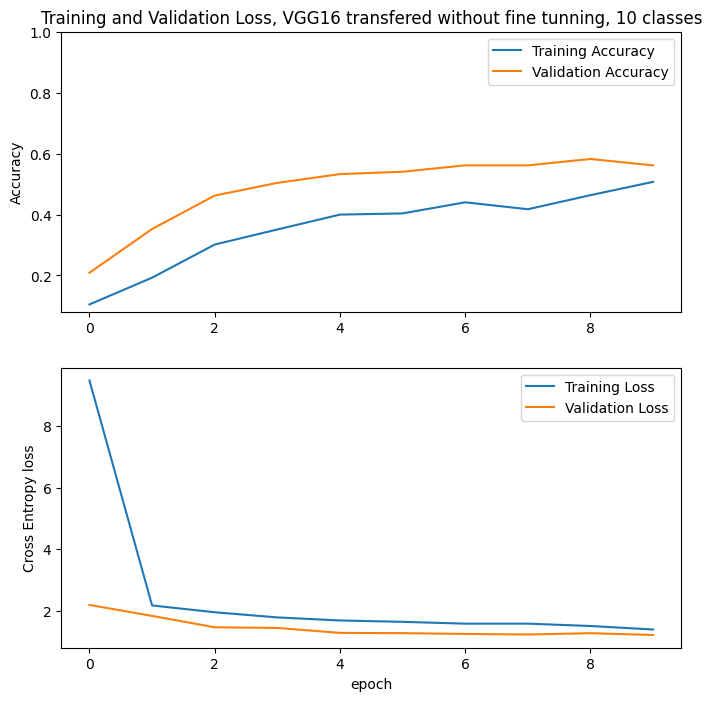

Found 1919 files belonging to 10 classes.
Using 1536 files for training.
Using 383 files for validation.


In [ ]:
#Testing a different batch size

BATCH_SIZE = 64

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="both",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

base_modelt = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,
                                               input_shape=(224, 224, 3),
                                               pooling=None,
                                               classes=10,
                                               classifier_activation='softmax')

#data augmentation layer
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(0.2),
                                        layers.RandomBrightness([-0.8,0.8])
                                        ])

# Freeze the base_model
base_modelt.trainable = False

# Create new model on top
inputst = tf.keras.Input(shape=(224,224,3))


xt1 = data_augmentation(inputst)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (0,1)
scale_layert = tf.keras.layers.Rescaling(scale=1 / 255)
xt2 = scale_layert(xt1)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
xt3 = base_modelt(xt2, training=False)


# Fully connected layers  
xt4 = Flatten()(xt3) 
xt5 = Dense(units = 4096, activation ='relu')(xt4) 
xt6 = Dense(units = 4096, activation ='relu')(xt5) 
outputt = Dense(units = 10, activation ='softmax')(xt6)

# creating the model

modelt = Model (inputs=inputst, outputs =outputt)

modelt.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])




model64 = train_model(model = modelt,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model3.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 transfered without fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")


BATCH_SIZE = 32


train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="both",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

In [ ]:

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
unfreeze_model(model)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_30 (Dense)            (None, 4096)              102764544 
                                                                 
 dense_31 (Dense)            (None, 4096)              167

## VGG16 fine tuning (10 classes)

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 1.4219 - accuracy: 0.4928
Epoch 1: val_accuracy improved from -inf to 0.59269, saving model to best_model5.h5
48/48 [==============================] - 11s 122ms/step - loss: 1.4219 - accuracy: 0.4928 - val_loss: 1.0871 - val_accuracy: 0.5927
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 1.2852 - accuracy: 0.5378
Epoch 2: val_accuracy improved from 0.59269 to 0.65274, saving model to best_model5.h5
48/48 [==============================] - 7s 138ms/step - loss: 1.2852 - accuracy: 0.5378 - val_loss: 0.9702 - val_accuracy: 0.6527
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.5749
Epoch 3: val_accuracy improved from 0.65274 to 0.68407, saving model to best_model5.h5
48/48 [==============================] - 7s 139ms/step - loss: 1.2014 - accuracy: 0.5749 - val_loss: 0.9177 - val_accuracy: 0.6841
Epoch 4/10
48/48 [==============================] - ETA: 0s - loss

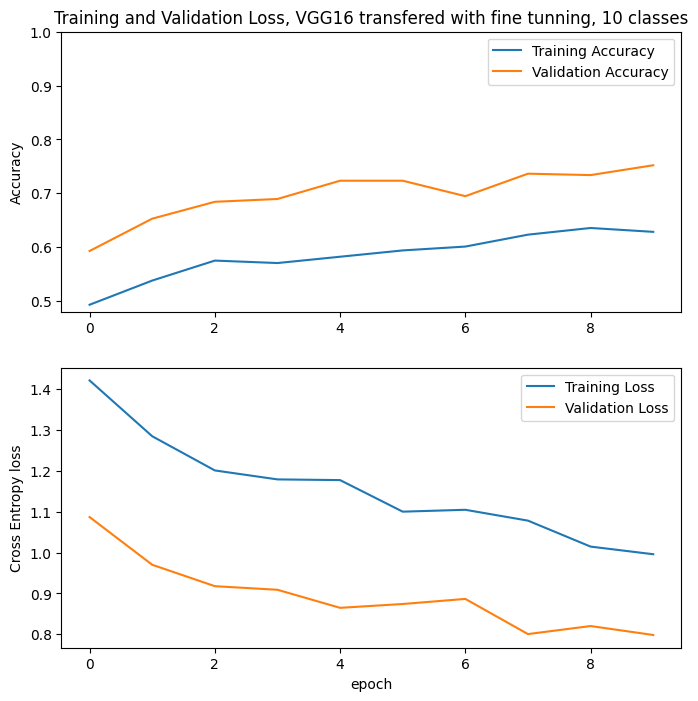

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model = train_model(model = model,
            train_data = train_ds,
            validation_data = val_ds,
            ModelCheckpointStr = 'best_model5.h5',
            MODEL_NAME = "Training and Validation Loss, VGG16 transfered with fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")

#callback early stopping, checkpoint ou model.save
#resnet50 ou efficientnet en tansfert

## EfficientNetB7 transfered (10 classes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found 1919 files belonging to 10 classes.
Using 1536 files for training.
Found 1919 files belonging to 10 classes.
Using 383 files for validation.


Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.8444
Epoch 1: val_accuracy improved from -inf to 0.98695, saving model to best_model6.h5
24/24 [==============================] - 75s 2s/step - loss: 1.1517 - accuracy: 0.8444 - val_loss: 0.0547 - val_accuracy: 0.9869
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.9160
Epoch 2: val_accuracy did not improve from 0.98695
24/24 [==============================] - 41s 2s/step - loss: 0.8371 - accuracy: 0.9160 - val_loss: 0.1094 - val_accuracy: 0.9634
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.8364 - accuracy: 0.9193
Epoch 3: val_accuracy did not improve from 0.98695
24/24 [==============================] - 41s 2s/step - loss: 0.8364 - accuracy: 0.9193 - val_loss: 0.1016 - val_accuracy: 0.9608
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.9401
Epoch 4: val_accuracy did not improve from 0.98695
24/24 [====

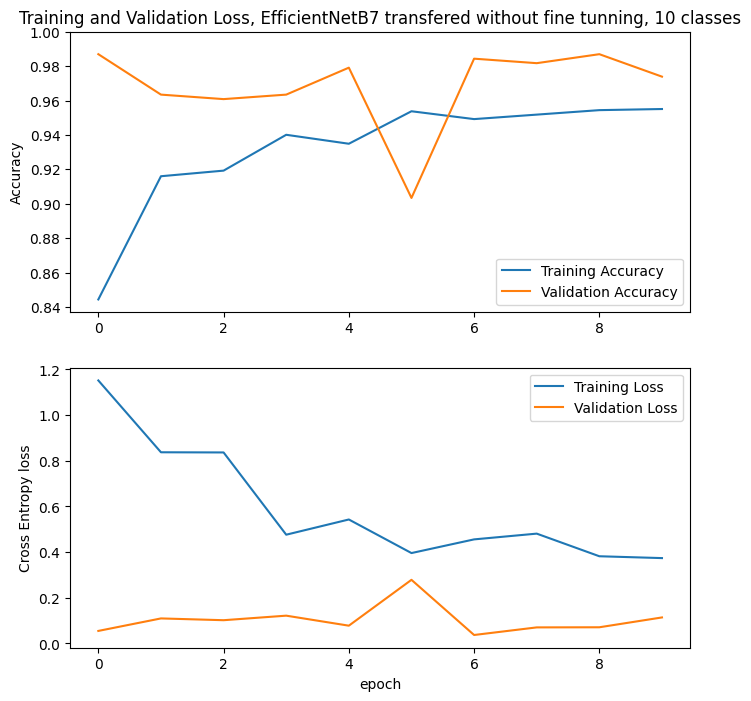

In [ ]:
#!!!!! BUG WITH TENSORFLOW 2.10, DOWNGRADE TO 2.9.1 !!!!!

!pip install tensorflow==2.9.1

from keras.applications import EfficientNetB7
BATCH_SIZE = 64
IMG_HEIGHT = 600
IMG_WIDTH = 600

NUM_CLASSES = 10

size = (IMG_HEIGHT, IMG_WIDTH)

data_dir = "drive/MyDrive/Images10"

ds_train_b7 = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="training",
                                                              label_mode = "int",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)


ds_test_b7 = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              label_mode = "int",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)



def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False,
                                                              input_tensor=x,
                                                              weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer,
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
         ,metrics=["accuracy"]
    )
    return model



model = build_model(num_classes=NUM_CLASSES)



model = train_model(model = model,
            train_data = ds_train_b7,
            validation_data = ds_test_b7,
            ModelCheckpointStr = 'best_model6.h5',
            MODEL_NAME = "Training and Validation Loss, EfficientNetB7 transfered without fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")



## EfficientNetB7 fine tuning (10 classes)

In [ ]:
unfreeze_model(model)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(
              optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=["accuracy"]
    )

model = train_model(model = model,
            train_data = ds_train_b7,
            validation_data = ds_test_b7,
            ModelCheckpointStr = 'best_model6.h5',
            MODEL_NAME = "Training and Validation Loss, EfficientNetB7 transfered with fine tunning, 10 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")


Epoch 1/10


ResourceExhaustedError: ignored

## EfficientNetB7 transfered (120 classes)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Epoch 1/10


258/258 [==============================] - ETA: 0s - loss: 3.3432 - accuracy: 0.6980
Epoch 1: val_accuracy did not improve from 0.95044
258/258 [==============================] - 457s 2s/step - loss: 3.3432 - accuracy: 0.6980 - val_loss: 0.2935 - val_accuracy: 0.9266
Epoch 2/10
258/258 [==============================] - ETA: 0s - loss: 1.2367 - accuracy: 0.7884
Epoch 2: val_accuracy did not improve from 0.95044
258/258 [==============================] - 428s 2s/step - loss: 1.2367 - accuracy: 0.7884 - val_loss: 0.2471 - val_accuracy: 0.9363
Epoch 3/10
258/258 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.8147
Epoch 3: val_accuracy did not improve from 0.95044
258/258 [==============================] - 428s 2s/step - loss: 0.7115 - accuracy: 0.8147 - val_loss: 0.1825 - val_accuracy: 0.9458
Epoch 4/10
258/258 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.8304
Epoch 4: val_accuracy did not improve from 0.95044
258/258 [==================

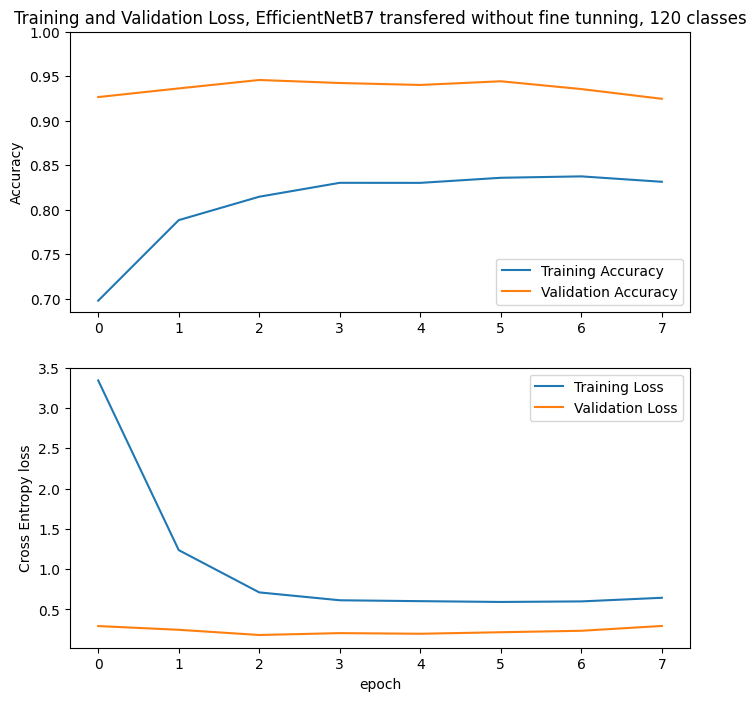

In [ ]:
#!!!!! BUG WITH TENSORFLOW 2.10, DOWNGRADE TO 2.9.1 !!!!!

from keras.applications import EfficientNetB7
BATCH_SIZE = 64
IMG_HEIGHT = 600
IMG_WIDTH = 600

NUM_CLASSES = 120

size = (IMG_HEIGHT, IMG_WIDTH)

data_dir = "drive/MyDrive/Images"

ds_train_b7 = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="training",
                                                              label_mode = "int",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)


ds_test_b7 = tf.keras.utils.image_dataset_from_directory(
                                                              data_dir,
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              label_mode = "int",
                                                              seed=42,
                                                              crop_to_aspect_ratio = False,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

img_augmentation2 = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation2",
)

def build_model2(num_classes):
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = img_augmentation2(inputs)
    model2 = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False,
                                                              input_tensor=x,
                                                              weights="imagenet")

    # Freeze the pretrained weights
    model2.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model2.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model2 = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model2.compile(
        optimizer=optimizer,
         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
         ,metrics=["accuracy"]
    )
    return model2


model120 = build_model2(num_classes=NUM_CLASSES)

model120 = train_model(model = model120,
            train_data = ds_train_b7,
            validation_data = ds_test_b7,
            ModelCheckpointStr = 'best_model8.h5',
            MODEL_NAME = "Training and Validation Loss, EfficientNetB7 transfered without fine tunning, 120 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")



## EfficientNetB7 fine tuning (120 classes)

Epoch 1/10


258/258 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.8376
Epoch 1: val_accuracy did not improve from 0.95068
258/258 [==============================] - 462s 2s/step - loss: 0.6175 - accuracy: 0.8376 - val_loss: 0.2802 - val_accuracy: 0.9288
Epoch 2/10
258/258 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.8418
Epoch 2: val_accuracy did not improve from 0.95068
258/258 [==============================] - 435s 2s/step - loss: 0.5990 - accuracy: 0.8418 - val_loss: 0.2674 - val_accuracy: 0.9317
Epoch 3/10
258/258 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.8448
Epoch 3: val_accuracy did not improve from 0.95068
258/258 [==============================] - 435s 2s/step - loss: 0.5825 - accuracy: 0.8448 - val_loss: 0.2558 - val_accuracy: 0.9344
Epoch 4/10
258/258 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.8478
Epoch 4: val_accuracy did not improve from 0.95068
258/258 [==================

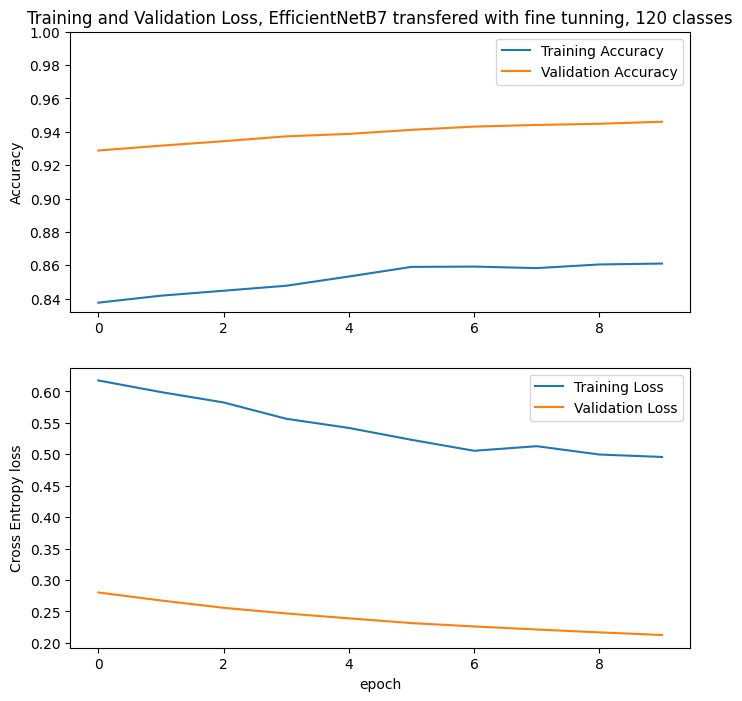

In [ ]:
unfreeze_model(model120)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
model120.compile(
              optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=["accuracy"]
    )

model120 = train_model(model = model120,
            train_data = ds_train_b7,
            validation_data = ds_test_b7,
            ModelCheckpointStr = 'best_model9.h5',
            MODEL_NAME = "Training and Validation Loss, EfficientNetB7 transfered with fine tunning, 120 classes",
            EPOCHS = 10,
            OPTIMIZER_NAME = "Adam",
            LOSS_FUNCTION = "SparseCategoricalCrossentropy")


## Conclusion :

We end up with a max precision of 95 % for all 120 classes wich is state of the art performance. 

We note a slight underfitting of the model, the hypothesis for this is the presence of the stanford dogs dataset in the original imagnet training.  